In [ ]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from concurrent.futures import ThreadPoolExecutor

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Побудування моделей без додаткових часових міток, лише на сирих файлах

### Зчитування, нормалізація, запис

In [ ]:
merged_data = pd.DataFrame()

In [ ]:
data_folder = '/content/drive/MyDrive/data'

In [ ]:
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                data = pd.read_csv(file_path)
                data['Activity'] = folder_name
                merged_data = pd.concat([merged_data, data], ignore_index=True)

In [ ]:
merged_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,0.421380,-0.033519,9.763555,idle
1,0.378284,-0.014365,9.763555,idle
2,0.454898,-0.095768,9.744401,idle
3,0.392649,-0.028730,9.777920,idle
4,0.368707,-0.014365,9.753978,idle


In [ ]:
output_file = 'merged_data.csv'
merged_data.to_csv(output_file, index=False)

In [ ]:
devices = pd.read_csv("merged_data.csv")

In [ ]:
devices.shape

(193860, 4)

In [ ]:
devices.head(10)

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,0.421380,-0.033519,9.763555,idle
1,0.378284,-0.014365,9.763555,idle
2,0.454898,-0.095768,9.744401,idle
3,0.392649,-0.028730,9.777920,idle
4,0.368707,-0.014365,9.753978,idle
5,0.359130,-0.019154,9.753978,idle
6,0.459687,-0.028730,9.782708,idle
7,0.383072,0.023942,9.749189,idle
8,0.421380,-0.028730,9.773131,idle
9,0.397437,-0.019154,9.734824,idle


In [ ]:
devices.dtypes

accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
Activity            object
dtype: object

In [ ]:
nulls = devices.iloc[:,1:].isnull().sum()/(len(devices.index)-1)
print("Частка пропусків\n")
print(nulls)

Частка пропусків

accelerometer_Y    0.0
accelerometer_Z    0.0
Activity           0.0
dtype: float64


In [ ]:
scaler = StandardScaler()

accelerometer_columns = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']

devices[accelerometer_columns] = scaler.fit_transform(devices[accelerometer_columns])
activities = listdir(data_folder)
devices.head(10)

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.178727,-0.130821,1.106665,idle
1,-0.183854,-0.129285,1.106665,idle
2,-0.174739,-0.135811,1.104001,idle
3,-0.182145,-0.130437,1.108662,idle
4,-0.184994,-0.129285,1.105333,idle
5,-0.186133,-0.129669,1.105333,idle
6,-0.174169,-0.130437,1.109328,idle
7,-0.183284,-0.126214,1.104667,idle
8,-0.178727,-0.130437,1.107996,idle
9,-0.181575,-0.129669,1.102670,idle


### Декілька графіків

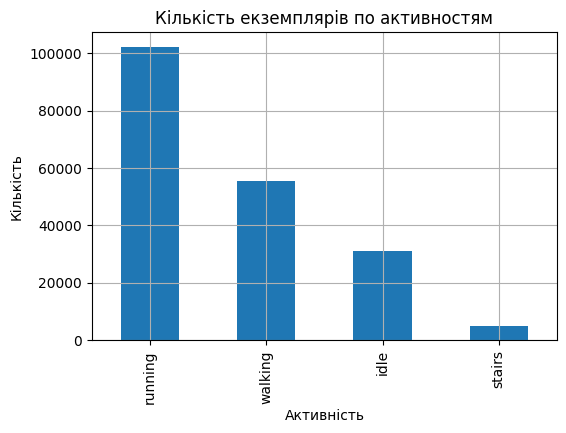

In [ ]:
plt.figure(figsize=(6, 4))
activity_counts = devices['Activity'].value_counts()
activity_counts.plot(kind='bar')
plt.title('Кількість екземплярів по активностям')
plt.xlabel('Активність')
plt.ylabel('Кількість')
plt.grid()
plt.show()

In [ ]:
grouped_data = devices.groupby('Activity').mean()

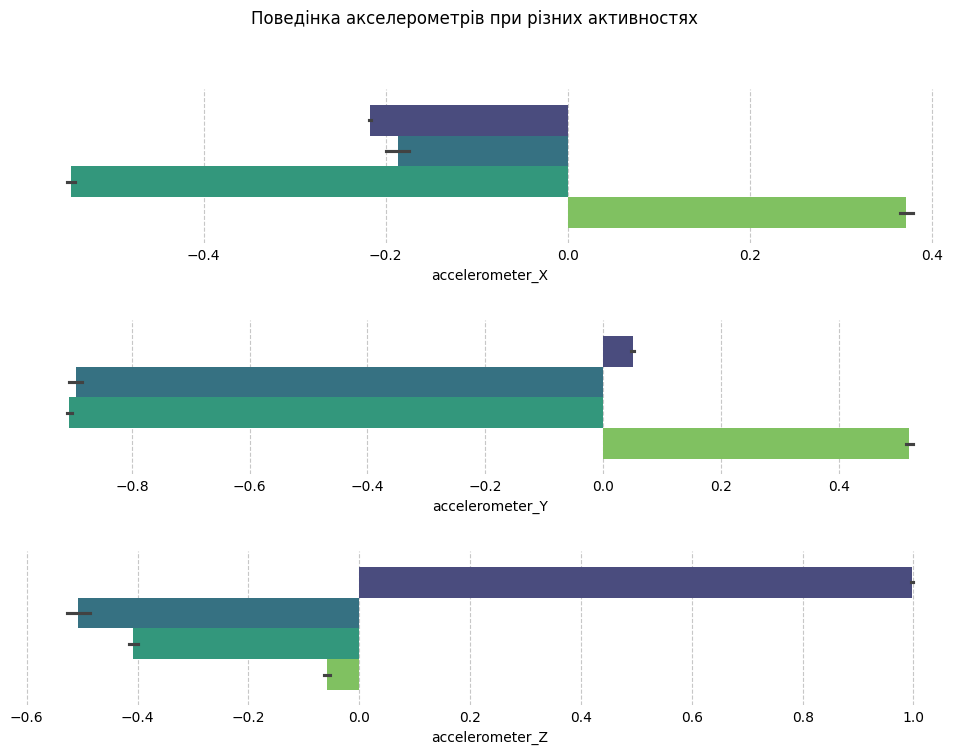

In [ ]:
fig, axes = plt.subplots(3, figsize=(12, 8))
fig.suptitle('Поведінка акселерометрів при різних активностях')
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, col in enumerate(devices.columns):
    if col != 'Activity':
        sns.barplot(x=col, data=devices, ax=axes[i], hue='Activity', palette='viridis', legend=False)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('')
        axes[i].set_title('')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].tick_params(axis='both', length=0)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)
        axes[i].set_axisbelow(True)

plt.show()

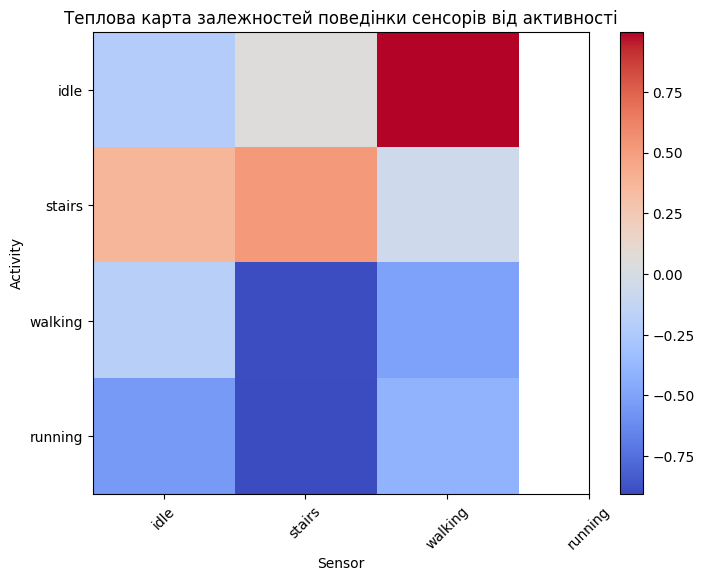

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(grouped_data, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(activities)), activities, rotation=45)
plt.yticks(range(len(activities)), activities)
plt.xlabel('Sensor')
plt.ylabel('Activity')
plt.title('Теплова карта залежностей поведінки сенсорів від активності')
plt.show()

### Побудова моделей та оцінка

Розбиття масиву даних на тренувальний та тестовий набіри

In [ ]:
X = devices.drop('Activity', axis=1)
y = devices['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ПОПЕРЕДЖЕННЯ!!! Від 6 до 15 хвилин!!!!
Виконувати не бажано, код закоментовано, результати наведені нижче
Побудова svm моделі та оцінка її результативності

In [ ]:
# svm = SVC()
# svm.fit(X_train, y_train)

# y_pred = svm.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')

# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

Висновок: побудова моделі опорних векторів на сирих даних - дуже ресурсоємна, час виконання - біля 15 хвилин, показники ефективнсті низькі:
Accuracy: 0.8937474248042852
Precision: 0.9003228561183134
Recall: 0.8937474248042852
F1-score: 0.883469491496501

Побудова моделі випадковий ліс та оцінка її результативності

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9997936655318271
Precision: 0.999793700526645
Recall: 0.9997936655318271
F1-score: 0.9997936101800868


Висновок: побудована модель випадкового лісу на сирих даних дуже швидка (18с) та з гарними показниками ефективності:
Accuracy: 0.9996652245570663
Precision: 0.9996653123277535
Recall: 0.9996652245570663
F1-score: 0.9996648288208538

## Зчитування з одночасним мануальним побудуванням додаткових ознак

### Підготовка та запис даних

Перевіряємо перелік активностей та кількість записів до кожної з них

In [ ]:
data_folder = '/content/drive/MyDrive/data'

activities = listdir(data_folder)

for activity in activities:
    path = join(data_folder, activity)
    frames = listdir(path)
    print(activity, " : ", len(frames))


idle  :  1039
stairs  :  165
walking  :  1850
running  :  3408


Задаємо список нових ознак які буде додано до дата сету

In [ ]:
time_domain_features = ['skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z',
                        'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z',
                        'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z',
                        'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']

Будуємо функцію для додавання нових ознак при обробці чанків даних

In [ ]:
def get_statistic_features(frame):
    features = []

    # Статистичні ознаки для кожної осі акселерометра
    for axis in ['X', 'Y', 'Z']:
        # Skew
        features.append(frame['accelerometer_' + axis].skew())

        # Kurtosis
        features.append(frame['accelerometer_' + axis].kurtosis())

        # Max
        features.append(frame['accelerometer_' + axis].max())

        # Min
        features.append(frame['accelerometer_' + axis].min())

        # Mean
        features.append(frame['accelerometer_' + axis].mean())

        # Standard Deviation
        features.append(frame['accelerometer_' + axis].std())

        # Variance
        features.append(frame['accelerometer_' + axis].var())

        # Median
        features.append(frame['accelerometer_' + axis].median())

        # Index of Maximum
        features.append(frame['accelerometer_' + axis].idxmax())

        # Index of Minimum
        features.append(frame['accelerometer_' + axis].idxmin())

        # Mean Absolute Error (MAE)
        features.append(np.abs(frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean()).mean())

        # Root Mean Squared Error (RMSE)
        features.append(np.sqrt(((frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean())**2).mean()))

    # Correlation between X and Y axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Y']))

    # Correlation between X and Z axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Z']))

    # Correlation between Y and Z axes
    features.append(frame['accelerometer_Y'].corr(frame['accelerometer_Z']))

    return features

Додаємо функцію процесінгу датасету зі зчитування даних та виклику попередньої фунції

In [ ]:
def process_data(data_folder, activities):
    columns = ['activity'] + time_domain_features
    features_list = []

    for activity in activities:
        path = join(data_folder, activity)
        frames = listdir(path)

        for frame_file in frames:
            frame = pd.read_csv(join(path, frame_file))
            features = get_statistic_features(frame)
            features_list.append([activity] + features)

    df = pd.DataFrame(features_list, columns=columns)
    return df

df = process_data(data_folder, activities)
df.shape

(6462, 40)

Записуємо до диску і надалі працюємо вже зі збереженими даними

In [ ]:
output_file = 'manual_engeneered_data.csv'
df.to_csv(output_file, index=False)

In [ ]:
engeneered_devices = pd.read_csv("manual_engeneered_data.csv")

engeneered_devices.head(10)

,activity,skew_X,skew_Y,skew_Z,kurtosis_X,kurtosis_Y,kurtosis_Z,max_X,max_Y,max_Z,...,idxmin_Z,mae_X,mae_Y,mae_Z,rmse_X,rmse_Y,rmse_Z,corr_XY,corr_XZ,corr_YZ
0,idle,0.150862,-0.067646,0.488417,0.330400,0.407972,0.034722,0.001206,0.404620,19,...,0.015953,0.000254,9.753978,21,26,0.013110,0.015684,-0.398087,0.114756,-0.099591
1,idle,0.171592,-0.187457,0.488417,0.330400,0.407334,0.035186,0.001238,0.404620,21,...,0.015764,0.000249,9.753978,23,28,0.012993,0.015499,-0.428464,0.098915,-0.128267
2,idle,0.176068,0.004637,0.488417,0.330400,0.407812,0.034509,0.001191,0.404620,17,...,0.016765,0.000281,9.749189,19,28,0.013365,0.016483,-0.378950,0.159436,-0.134423
3,idle,0.427877,-0.169211,0.488417,0.330400,0.399193,0.037819,0.001430,0.390255,27,...,0.016670,0.000278,9.753978,29,5,0.014344,0.016390,-0.338821,0.164114,-0.080443
4,idle,0.277124,-0.191366,0.488417,0.330400,0.403024,0.036793,0.001354,0.392649,25,...,0.015943,0.000254,9.753978,27,3,0.013567,0.015675,-0.366559,0.169142,-0.061500
5,idle,-0.022002,0.007895,0.488417,0.320823,0.401747,0.038294,0.001466,0.395043,15,...,0.016074,0.000258,9.751584,17,26,0.012450,0.015804,-0.135528,0.162348,-0.191794
6,idle,0.209641,-0.170463,0.488417,0.330400,0.406855,0.035176,0.001237,0.404620,23,...,0.015936,0.000254,9.753978,25,1,0.013471,0.015668,-0.436739,0.096465,-0.158989
7,idle,-0.135651,0.278690,0.488417,0.320823,0.403822,0.037374,0.001397,0.404620,13,...,0.016108,0.000259,9.751584,15,24,0.012610,0.015837,-0.147454,0.161095,-0.179030
8,idle,-0.035862,0.395431,0.488417,0.320823,0.400630,0.036453,0.001329,0.395043,11,...,0.015936,0.000254,9.751584,13,22,0.012769,0.015668,-0.140023,0.061239,-0.164939
9,idle,3.352165,13.067659,3.739743,-1.072602,0.212126,0.821512,0.674882,0.071826,25,...,1.390242,1.932773,8.535329,20,25,0.920012,1.366875,0.453838,-0.768491,-0.804039


Окремо перевіряємо список ознак

In [ ]:
print(engeneered_devices.columns.tolist())

['activity', 'skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z', 'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z', 'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z', 'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']


### Декілька графиків для візуалізації датасету

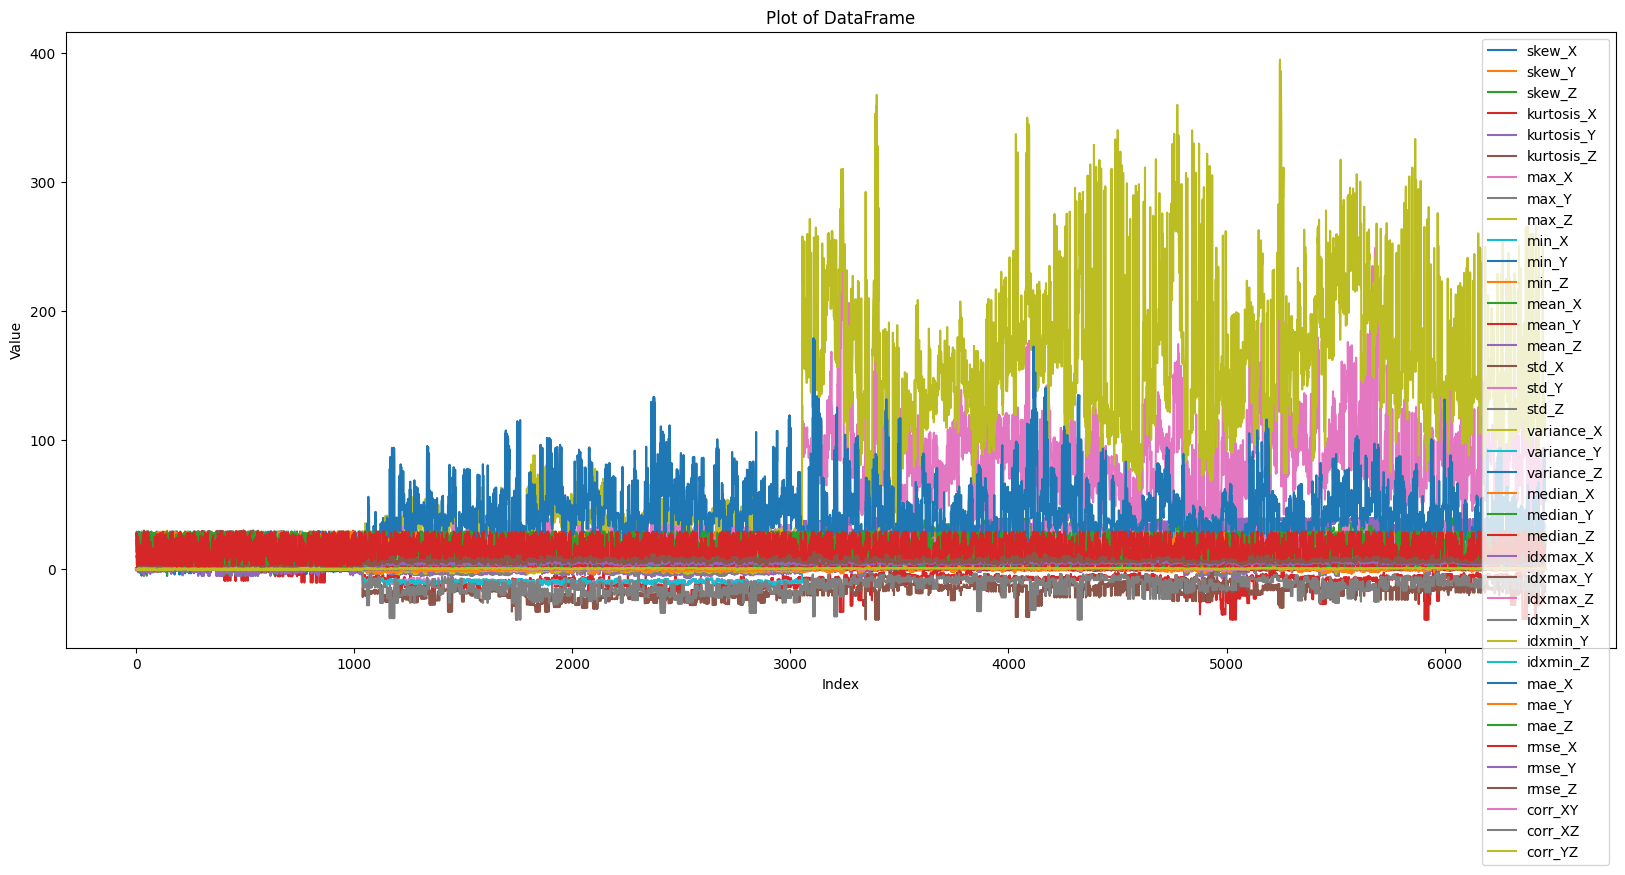

In [ ]:

engeneered_devices.plot(figsize=(20, 8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of DataFrame')
plt.show()

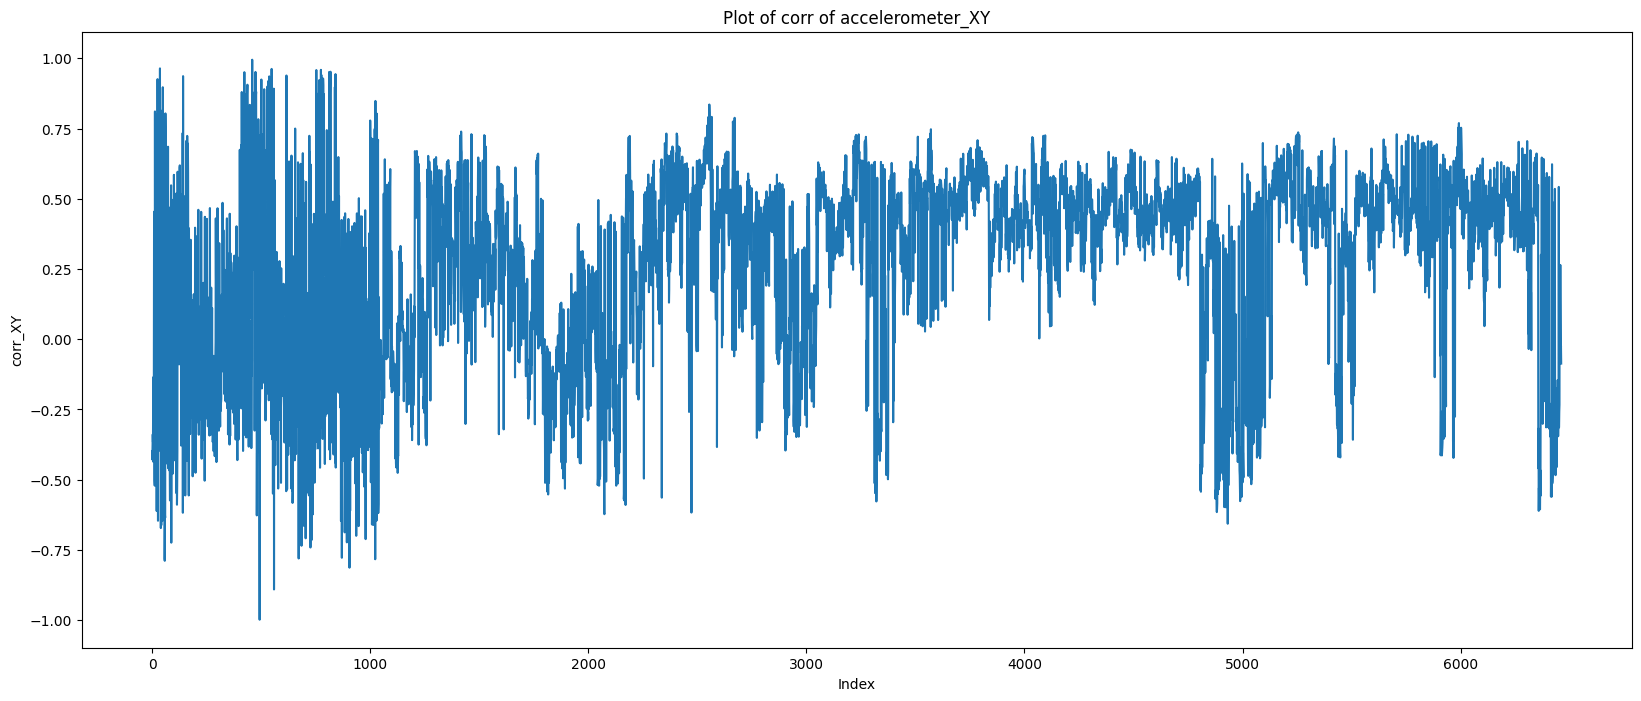

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(engeneered_devices['corr_XY'])
plt.xlabel('Index')
plt.ylabel('corr_XY')
plt.title('Plot of corr of accelerometer_XY')
plt.show()

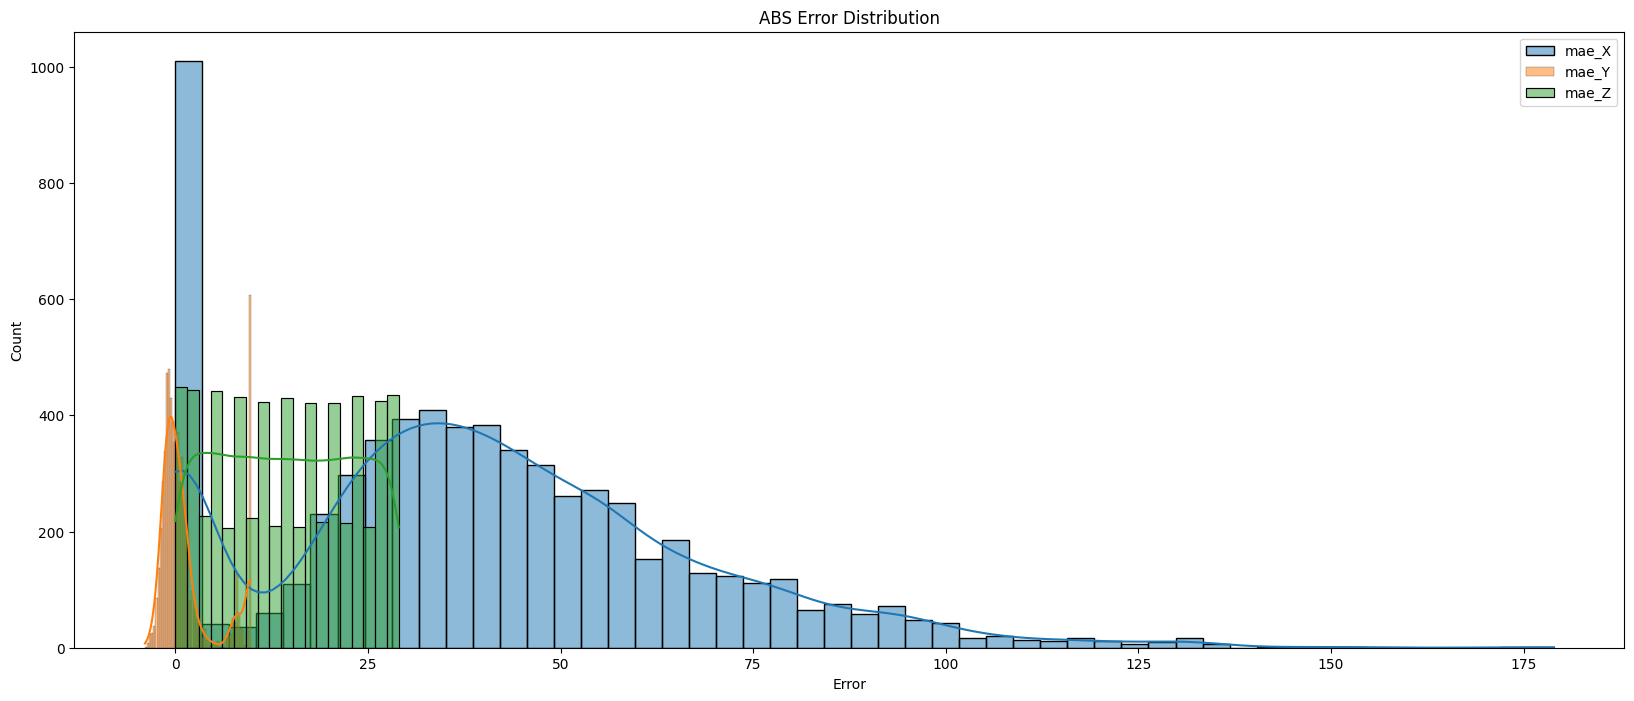

In [ ]:
error_cols = ['mae_X', 'mae_Y', 'mae_Z']

# Графік розподілу помилок
plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('ABS Error Distribution')
plt.legend()
plt.show()

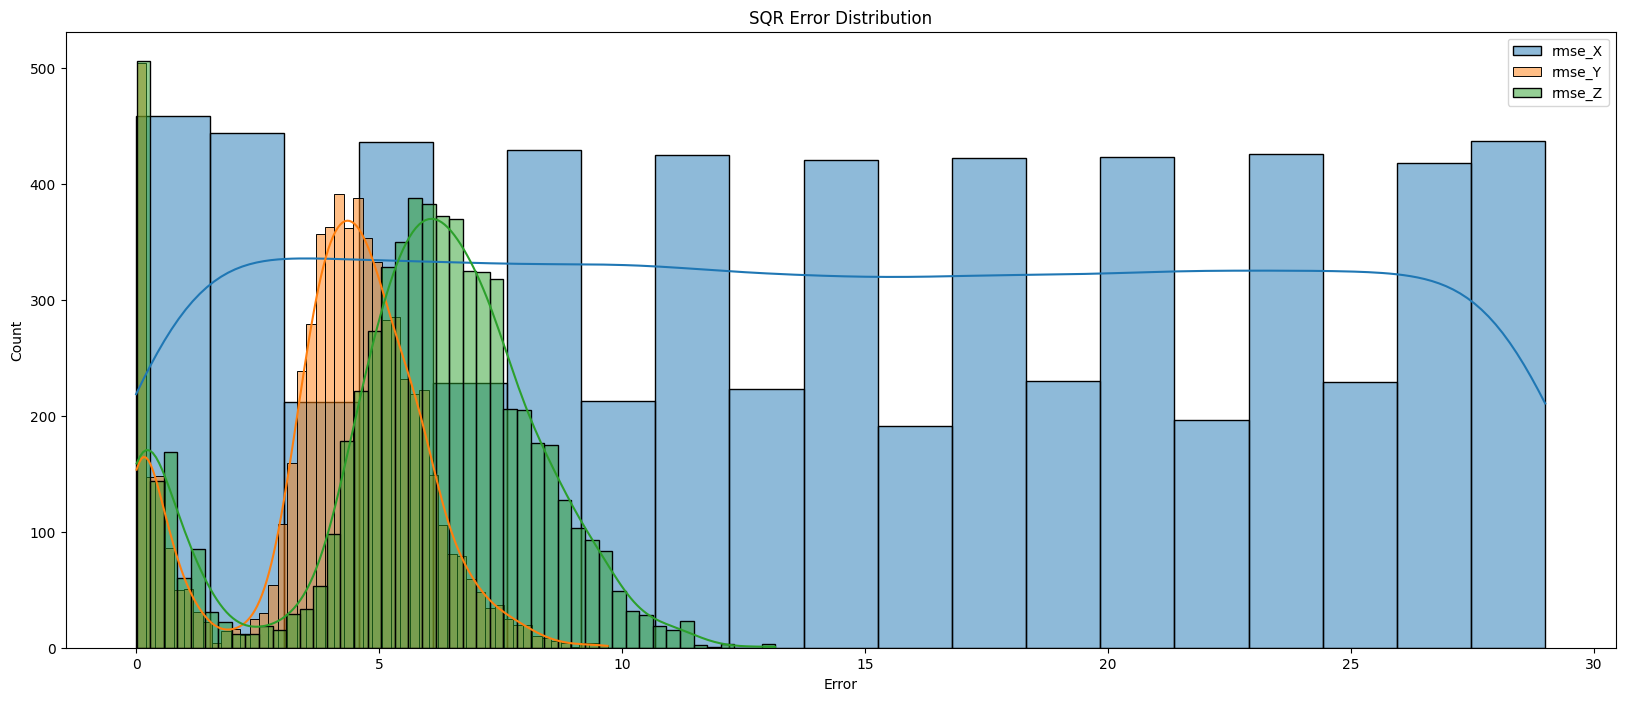

In [ ]:
error_cols = ['rmse_X', 'rmse_Y', 'rmse_Z']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('SQR Error Distribution')
plt.legend()
plt.show()

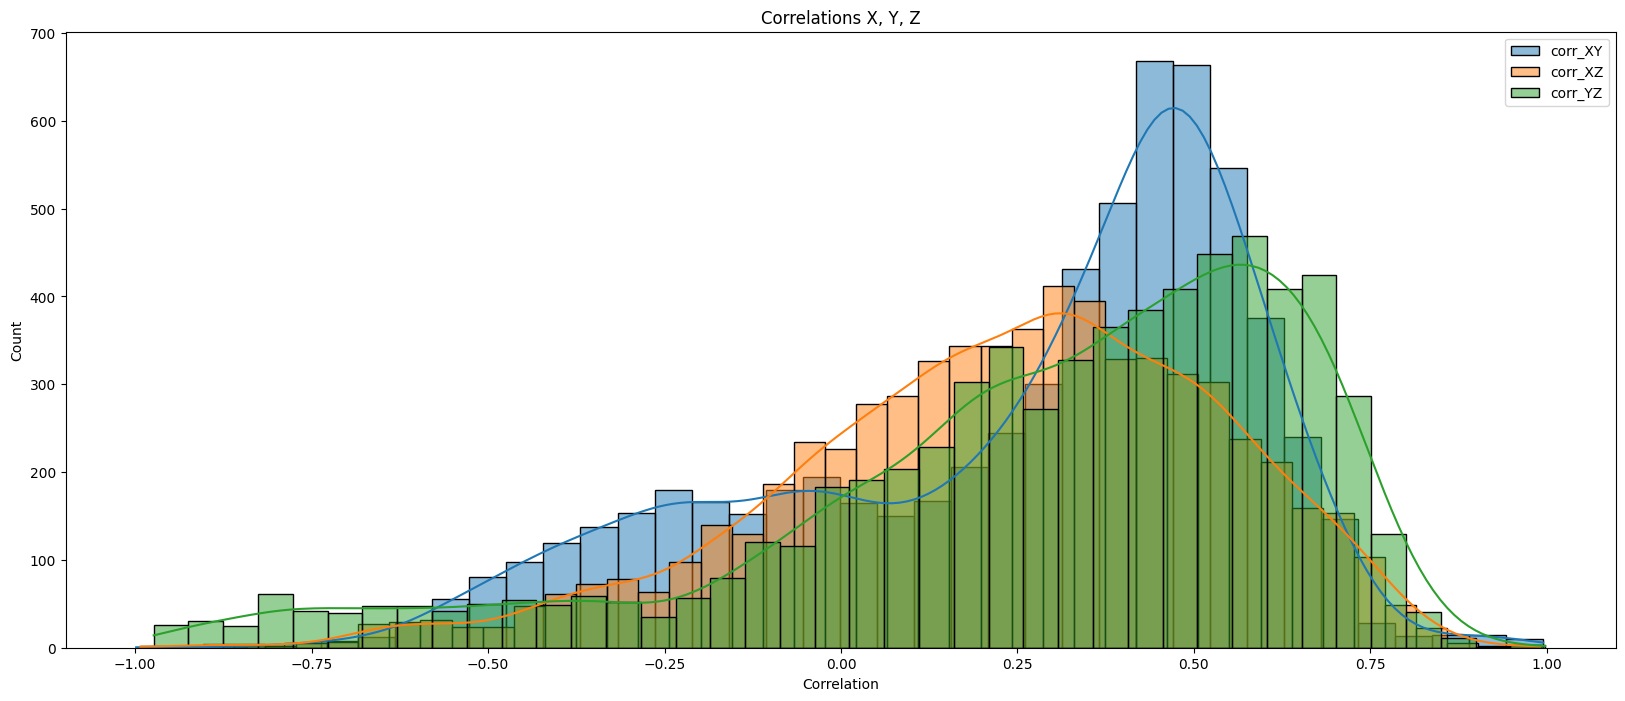

In [ ]:
error_cols = ['corr_XY', 'corr_XZ', 'corr_YZ']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Correlations X, Y, Z')
plt.legend()
plt.show()

### Побудова моделей та їх аналіз

In [ ]:
X = engeneered_devices.drop('activity', axis=1)
y = engeneered_devices['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Побудова нерегулюємих моделей SVM та  RandomForest

In [ ]:
# Модель SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy (SVM):", accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1-score (SVM):", f1_svm)

# Модель RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\nAccuracy (RandomForest):", accuracy_rf)
print("Precision (RandomForest):", precision_rf)
print("Recall (RandomForest):", recall_rf)
print("F1-score (RandomForest):", f1_rf)

Accuracy (SVM): 0.9969064191802011
Precision (SVM): 0.9969064191802011
Recall (SVM): 0.9969064191802011
F1-score (SVM): 0.9969064191802011

Accuracy (RandomForest): 0.9984532095901005
Precision (RandomForest): 0.9984615256675731
Recall (RandomForest): 0.9984532095901005
F1-score (RandomForest): 0.9984311256131397


Висновок: побудовані на мануально зінженірених ознаках моделі випадкового лісу та опорних векторів показали високу швидкість (1,7 с на дві моделі) та ефективність 0.995 -0.999

#### Побудова регулюємих моделей SVM та  RandomForest

In [ ]:
# Списки параметрів для моделей
svm_params = [{'kernel': 'linear'}, {"C": 10, 'kernel': 'linear'}, {'kernel': 'rbf', 'gamma': 0.1},
              {'kernel': 'rbf', 'gamma': 0.01},  {'kernel': 'poly', 'degree': 2}, {'kernel': 'poly', 'degree': 5}]
rf_params = [{'n_estimators': 100, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 20},
             {'n_estimators': 200, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 5}]


In [ ]:

# Цикл для навчання та оцінки моделей з різними параметрами
for svm_param in svm_params:
    svm_model = SVC(**svm_param, probability=True)
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
    recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=1)

    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

    print("\nSVM Parameters:", svm_param)
    print("Accuracy (SVM):", accuracy_svm)
    print("Precision (SVM):", precision_svm)
    print("Recall (SVM):", recall_svm)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, svm_model.predict(X_train), average='weighted'), "test:", f1_svm)




SVM Parameters: {'kernel': 'linear'}
Accuracy (SVM): 0.9969064191802011
Precision (SVM): 0.9969064191802011
Recall (SVM): 0.9969064191802011
Overfitting check F1-score:  train: 0.9980653898239504 test: 0.9969064191802011

SVM Parameters: {'C': 10, 'kernel': 'linear'}
Accuracy (SVM): 0.9961330239752514
Precision (SVM): 0.9961970728847
Recall (SVM): 0.9961330239752514
Overfitting check F1-score:  train: 0.9984523118591604 test: 0.9961592656480306

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.1}
Accuracy (SVM): 0.5274555297757154
Precision (SVM): 0.7507538061152652
Recall (SVM): 0.5274555297757154
Overfitting check F1-score:  train: 1.0 test: 0.3642781481590257

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.01}
Accuracy (SVM): 0.8894044856921887
Precision (SVM): 0.9085743748388759
Recall (SVM): 0.8894044856921887
Overfitting check F1-score:  train: 1.0 test: 0.8856016063642621

SVM Parameters: {'kernel': 'poly', 'degree': 2}
Accuracy (SVM): 0.9721577726218097
Precision (SVM): 0.9743854862

In [ ]:
for rf_param in rf_params:
    rf_model = RandomForestClassifier(random_state=42, **rf_param)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
    #auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')
    auc_prc_rf = []
    for i in range(len(rf_model.classes_)):
        class_scores = rf_model.predict_proba(X_test)[:, i]
        class_labels = np.where(y_test == rf_model.classes_[i], 1, 0)
        auc_prc = average_precision_score(class_labels, class_scores)
        auc_prc_rf.append(auc_prc)



    print("\nRandomForest Parameters:", rf_param)
    print("Accuracy (RandomForest):", accuracy_rf)
    print("Precision (RandomForest):", precision_rf)
    print("Recall (RandomForest):", recall_rf)
    #print("AUC-ROC:", auc_roc_rf)
    print("AUC-PRC:", auc_prc_rf)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, rf_model.predict(X_train), average='weighted'), "test:", f1_rf)


RandomForest Parameters: {'n_estimators': 100, 'max_depth': 10}
Accuracy (RandomForest): 0.9969064191802011
Precision (RandomForest): 0.9969395056060812
Recall (RandomForest): 0.9969064191802011
AUC-PRC: [1.0, 1.0, 0.9883865391886782, 0.9998585235848942]
Overfitting check F1-score:  train: 0.999806203853973 test: 0.9968149423280028

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 10}
Accuracy (RandomForest): 0.9969064191802011
Precision (RandomForest): 0.9969395056060812
Recall (RandomForest): 0.9969064191802011
AUC-PRC: [1.0, 1.0, 0.9880094652821925, 0.9998508672033004]
Overfitting check F1-score:  train: 0.999806203853973 test: 0.9968149423280028

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 20}
Accuracy (RandomForest): 0.9976798143851509
Precision (RandomForest): 0.9976984753954579
Recall (RandomForest): 0.9976798143851509
AUC-PRC: [1.0, 1.0, 0.9901051329622759, 0.9998813718559024]
Overfitting check F1-score:  train: 1.0 test: 0.997629255959909

RandomFor

Висновок: при побудові декількох варіантів для кожної моделі бачимо що:
- метод опорних векторів  справляється гірше (6 моделей - 1 хв.):
    - на RBF kernel - f1 від 0,3 до 0,9, та спостерігається перенавчання
    - на polynomial kernel  - f1 від 0,94 до 0,95, перенавчання відсутнє
    - найкращі результати у лінійної моделі - f1 від 0,996 до 0,998, перенавчання майже відсутнє
- метод випадкового лісу при різноманітних параметрах показав найбільшу ефективність (6 моделей - 15 сек) - f1 від 0,987 до 0,999, при змінах параметрів спостерігається деяке перенавчання